In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
#import functions
#import objects
from types import SimpleNamespace
import syntheticData
import matplotlib
from matplotlib import cm
import ast
import h5py
import pickle as pkl

In [3]:
file = open("C:/Users/vkuma/Research/LearningDiffusionMaps/1000 1 45variables.pkl", "rb")
variables = pkl.load(file)
file = open("C:/Users/vkuma/Research/LearningDiffusionMaps/1000 1 45data.pkl", "rb")
data = pkl.load(file)
variables.dInduPrior

6.283347901353638

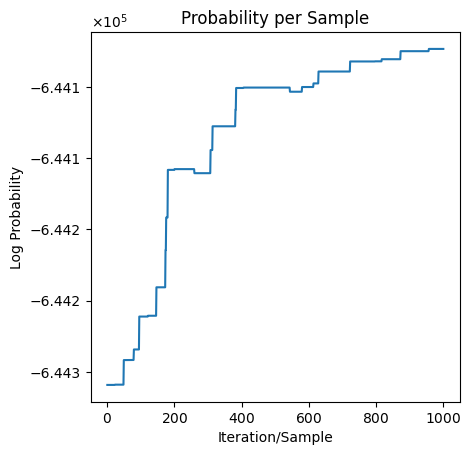

In [5]:
file = "C:/Users/vkuma/Research/LearningDiffusionMaps/1000(1 45).h5"
f = h5py.File(file, 'r')
dVect= f['samples'][()]
pVect = f['prob'][()]
fig, ax = plt.subplots(1, 1)
plt.plot(pVect)
plt.title("Probability per Sample")
plt.xlabel("Iteration/Sample")
plt.ylabel("Log Probability")
plt.ticklabel_format(useMathText=True)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.3f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yScalarFormatter)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')


In [8]:
len(np.unique(pVect))/len(pVect)*100

2.797202797202797

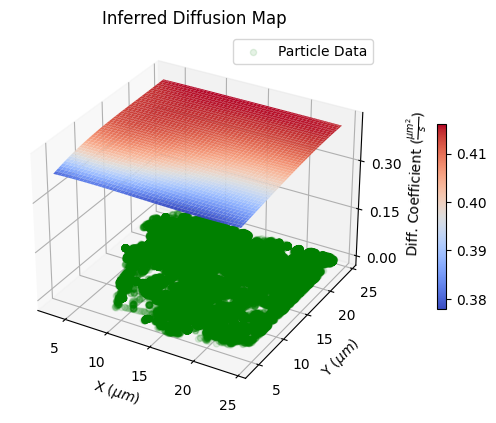

In [14]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = (cInduFine.T @ (cInduInduInv @ np.mean(dVect, 0)))

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)




#generate contour plot
fig = plt.axes(projection='3d')
fig.plot_surface(shapedX, shapedY, shapedMap, cmap=cm.coolwarm)
fig.scatter3D(trajectories[:,0], trajectories[:,1], 0, color = "green", alpha = 0.1, label = "Particle Data")
#fig.scatter3D(induCoordinates[:,0], induCoordinates[:,1], 0, color = "black", alpha = 0.5, label = "Inducing Points")
fig.set_xlabel(r"X ($\mu m$)")
fig.set_ylabel(r"Y ($\mu m$)")
fig.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
fig.set_title("Inferred Diffusion Map")
ticks = np.arange(0, 45, 15)/100
fig.legend()
fig.set_zticks(ticks)
norm = matplotlib.colors.Normalize(vmin=np.min(shapedMap), vmax=np.max(shapedMap))
m = cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
m.set_array([])
plt.colorbar(m, shrink = 0.5, anchor = (0.5, 0.5));

In [ ]:
#read datafile
with open("C:/Users/vkuma/Downloads/data_to_share.txt") as inp:
    tempData = [i.strip().split('\t') for i in inp]

#clean the data
cleanData = []
for i in tempData:
    if i != ['']:
        cleanData.append(i)

#coordinates for trajectories
x = np.array([float(i[2]) for i in cleanData])
y = np.array([float(i[3]) for i in cleanData])

# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = np.array([int(i[0]) for i in cleanData])
data.trajectories = np.vstack((x,y)).T
data.deltaT = 0.0001
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)



In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/250000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/250000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/250000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/250000samples(1 10).csv')

dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/(1 20)/850000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/(1 20)/850000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/400000probability(1 20).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/data/mix map samples/400000samples(1 20).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
#necassary variables
nFineX = variables.nFineX
nFineY = variables.nFineY
cInduFine = variables.cInduFine
cInduInduInv = variables.cInduInduInv
fineCoordinates = variables.fineCoordinates
trajectories = data.trajectories
induCoordinates = variables.induCoordinates 

#shape for plot
shape = (nFineX, nFineY)

#take mean of all samples
unshapedMap = cInduFine.T @ cInduInduInv @ np.mean(dVect, 0)

#reshape variables to make plotting easy
shapedMap = np.reshape(unshapedMap, shape)/1000
shapedX = np.reshape(fineCoordinates[:,0], shape)
shapedY = np.reshape(fineCoordinates[:,1], shape)




#generate contour plot
fig = plt.axes(projection='3d')
fig.plot_surface(shapedX, shapedY, shapedMap, cmap=cm.coolwarm)
fig.scatter3D(trajectories[:,0], trajectories[:,1], 0, color = "green", alpha = 0.1, label = "Particle Data")
fig.scatter3D(induCoordinates[:,0], induCoordinates[:,1], 0, color = "black", alpha = 0.5, label = "Inducing Points")
fig.set_xlabel(r"X ($\mu m$)")
fig.set_ylabel(r"Y ($\mu m$)")
fig.set_zlabel(r"Diff. Coefficient ($\frac{\mu m^2}{s}$)")
fig.set_title("Inferred Diffusion Map")
ticks = np.arange(0, 20/1000, 5/1000)
fig.legend()
fig.set_zticks(ticks)

In [ ]:
#generate plot
fig, ax = plt.subplots(1, 1)
plt.plot(pVect[100:])
plt.title("Probability per Sample")
plt.xlabel("Iteration/Sample")
plt.ylabel("Log Probability")
plt.ticklabel_format(useMathText=True)
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter)
class ScalarFormatterClass(ticker.ScalarFormatter):
   def _set_format(self):
      self.format = "%1.2f"
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((0,0))
ax.yaxis.set_major_formatter(yScalarFormatter)
#ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/250000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/250000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)


In [ ]:
#read datafile
file = open("C:/Users/vkuma/Research/GPcurve/syntheticData2Gauss.txt")
fullArray = np.loadtxt(file,delimiter = ",")

#coordinates for trajectories
x = fullArray[:,1]
y = fullArray[:,2]
# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = fullArray[:,0]
data.trajectories = np.vstack((x,y)).T
data.deltaT = 1
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/150000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/150000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
syntheticData.plots(variables, dVect, pVect)

In [ ]:
#read datafile
file = open("C:/Users/vkuma/Research/GPcurve/syntheticData2Gauss.csv")
fullArray = np.loadtxt(file,delimiter = ",")

#coordinates for trajectories
x = fullArray[:,1]
y = fullArray[:,2]
# Initialize variables
data = SimpleNamespace(**objects.DATA)
data.trajectoriesIndex = fullArray[:,0]
data.trajectories = np.vstack((x,y)).T
data.deltaT = 1
data.nData = len(data.trajectoriesIndex)
data.nTrajectories = np.unique(data.trajectoriesIndex)

variables = functions.initialization(objects.PARAMETERS, data, 1, 10)

In [ ]:
pVect = []
with open('C:/Users/vkuma/Research/GPcurve/150000probability(1 10).csv') as file_obj:
      
    # Create reader object by passing the file 
    # object to reader method
    reader_obj = csv.reader(file_obj)
      
    # Iterate over each row in the csv 
    # file using reader object
    for row in reader_obj:
        pVect.append(float(row[0]))

file = open('C:/Users/vkuma/Research/GPcurve/150000samples(1 10).csv')
dVect = np.loadtxt(file,delimiter = ",")

In [ ]:
plot5 = functions.plotThreeD(variables, dVect, data)
plot1 = functions.plots(variables, dVect, pVect, data)
plot2 = functions.probPlot(pVect)
plot3 = functions.probPlot(pVect[100:])
plot4 = functions.meanPlot(variables, dVect, data)

In [ ]:
syntheticData.plots(variables, dVect, pVect)
syntheticData.diffPlot(variables, dVect, pVect)
syntheticData.meanPlot(variables, dVect, pVect)

In [ ]:
import numpy as np

matrix1 = np.random.rand(2500,250000)
matrix2 = np.random.rand(250000,2500)

result = matrix1 @ matrix2

print(result)


In [ ]:
result = matrix1 @ matrix2

print(result)

In [ ]:
x = [19.7, 19.6, 19.4, 19.2, 19, 18.8, 18.6, 18.4, 18.2, 18]

a, b = np.polyfit(x, y, 1)